In [5]:
import pandas as pd
from collections import defaultdict
import warnings
import visualize
import neat
import multiprocessing
import os
import matplotlib.pyplot as plt

import numpy as np

from sklearn.datasets import load_digits
digits = load_digits()

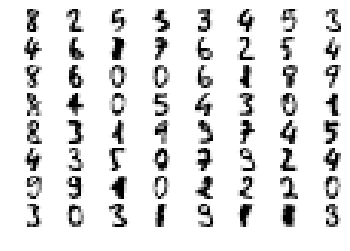

In [6]:
from random import randint

for i in range(64):
    ax = plt.subplot(8, 8, i+1)
    ax.axis('off')
    plt.imshow(digits.images[randint(0, digits.images.shape[0])], cmap='Greys')
plt.show()

In [7]:
X = digits.images.reshape(digits.images.shape[0], digits.images.shape[1] * digits.images.shape[2])
y = digits.target

In [8]:
def softmax(x, axis=1):
    # 计算每行的最大值
    row_max = x.max(axis=axis)
 
    # 每行元素都需要减去对应的最大值，否则求exp(x)会溢出，导致inf情况
    row_max=row_max.reshape(-1, 1)
    x = x - row_max
 
    # 计算e的指数次幂
    x_exp = np.exp(x)
    x_sum = np.sum(x_exp, axis=axis, keepdims=True)
    s = x_exp / x_sum
    return s

In [9]:
def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        
        outputs = []
        for xi in x_inputs:
            output = net.activate(xi)
            outputs.append(output)
        
        
        px_outputs = softmax(np.array(outputs).reshape(samplesize, number_of_classification), axis=1)
        # the index of maximum in each line
        pred_outputs = np.argmax(px_outputs, axis = 1)
        # replace index to real number, from higher number to lower number!!
        for i in range(number_of_classification):
            index = number_of_classification - i - 1
            pred_outputs[pred_outputs==index] = numbers[index]
        
        real_outputs = np.array(x_outputs).reshape(samplesize,)
        
        acc = np.sum(pred_outputs == real_outputs)/samplesize

        genome.fitness = acc

In [10]:
numbers = [*range(10)] # number 2 > number 1
number_of_classification = len(numbers)
number_of_sampling = 100
##？？ 删除number of sampling


list_y = y.tolist()
digits_indexes = []
for digit in numbers:
    li = [i for i in range(len(list_y)) if list_y[i] == digit]
    digits_indexes.extend(li[:number_of_sampling])

samplesize = X[digits_indexes].shape[0]
x_inputs =[tuple(c) for c in X[digits_indexes].tolist()]
x_outputs = [tuple(c) for c in y[digits_indexes].reshape(samplesize,1).tolist()]

In [11]:
def run(config_file):
    # Load configuration.
    config = neat.Config(
        neat.DefaultGenome,
        neat.DefaultReproduction,
        neat.DefaultSpeciesSet,
        neat.DefaultStagnation,
        config_file,
    )

    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)

    # add a stdout reporter to show progress in the terminal
    reporter = neat.StdOutReporter(False)
    p.add_reporter(reporter)
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    #checkpointer = neat.Checkpointer(100)
    #p.add_reporter(checkpointer)
    # Run for up to 300 generations.
    winner = p.run(eval_genomes, 10)

    return [stats, winner]


samplesize = len(x_outputs)

local_dir = os.getcwd()
config_path = os.path.join(local_dir, "config-feedforward-mnist"+str(number_of_classification))
[stats, winner] = run(config_path)

config = neat.Config(
    neat.DefaultGenome,
    neat.DefaultReproduction,
    neat.DefaultSpeciesSet,
    neat.DefaultStagnation,
    config_path,
)
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)


 ****** Running generation 0 ****** 

Population's average fitness: 0.09612 stdev: 0.03972
Best fitness: 0.20300 - size: (10, 64) - species 10 - id 189
Average adjusted fitness: 0.096
Mean genetic distance 2.824, standard deviation 0.286
Population of 202 members in 46 species
Total extinctions: 0
Generation time: 8.190 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.11211 stdev: 0.04109
Best fitness: 0.25300 - size: (10, 65) - species 2 - id 320
Average adjusted fitness: 0.111
Mean genetic distance 2.896, standard deviation 0.335
Population of 207 members in 48 species
Total extinctions: 0
Generation time: 8.970 sec (8.580 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.12264 stdev: 0.03824
Best fitness: 0.25300 - size: (10, 65) - species 43 - id 320
Average adjusted fitness: 0.083
Mean genetic distance 2.920, standard deviation 0.343
Population of 210 members in 48 species
Total extinctions: 0
Generation time: 9.539 sec (8.9

In [12]:
# program to check if there is exist a path between two vertices 
# of a graph 

from collections import defaultdict 

#This class represents a directed graph using adjacency list representation 
class Graph: 

	def __init__(self,vertices): 
		self.V= vertices #No. of vertices 
		self.graph = defaultdict(list) # default dictionary to store graph 

	# function to add an edge to graph 
	def addEdge(self,u,v): 
		self.graph[u].append(v) 
	
	# Use BFS to check path between s and d 
	def isReachable(self, s, d): 
		# Mark all the vertices as not visited 
		visited =[False]*(self.V) 

		# Create a queue for BFS 
		queue=[] 

		# Mark the source node as visited and enqueue it 
		queue.append(s) 
		visited[s] = True

		while queue: 

			#Dequeue a vertex from queue 
			n = queue.pop(0) 
			
			# If this adjacent node is the destination node, 
			# then return true 
			if n == d: 
				return True

			# Else, continue to do BFS 
			for i in self.graph[n]: 
				if visited[i] == False: 
					queue.append(i) 
					visited[i] = True
		# If BFS is complete without visited d 
		return False
    
    
def findAllPath(graph,start,end,path=[]):
    path = path +[start]
    if start == end:
        return [path]
 
    paths = [] #存储所有路径    
    for node in graph[start]:
        if node not in path:
            newpaths = findAllPath(graph,node,end,path) 
            for newpath in newpaths:
                paths.append(newpath)
    return paths

In [13]:
used_nodes = list(winner.nodes.keys())
# create a dict for mapping 
l1 = numbers + config.genome_config.input_keys + used_nodes[number_of_classification:]
l2 = range(len(l1))
dict_nodes = dict(zip(l1, l2))

### 将节点加入图
g = Graph(len(l1))# inputs + outputs + used  
# add connections in the graph
for cg in winner.connections.values():
    if cg.enabled:
        g.addEdge(dict_nodes[cg.key[0]],dict_nodes[cg.key[1]])
        
v = numbers
list_connections = []
for vi in v:
    for u in range(number_of_classification, len(config.genome_config.input_keys) + number_of_classification):
        list_connections.append(g.isReachable(u, vi))

nodes_inputs = range(number_of_classification, number_of_classification+ 64)
nodes_outputs = range(number_of_classification)
nodes_mid = range(number_of_classification + 64, len(dict_nodes))

# 找到所有输入和输出连接的路
all_path = []
for u in nodes_inputs:
    for v in nodes_outputs:
        path = findAllPath(g.graph, u, v)
        if path:
            all_path = all_path + path

# 得到最长路，以及每个节点在哪个层级
max_length = max([len(x) for x in all_path])
nodes_tuples_list = []
for path in all_path:
    #print(path)
    for node in path:
        nodes_tuples_list.append([node, path.index(node)])

# 确定节点的层级（消除重复）       
nodes_tuples_fixed_list = []
for index in range(max_length):
    for nodes in nodes_tuples_list:
        node, node_index = nodes[0], nodes[1]
        if node_index == index: 
            if nodes not in nodes_tuples_fixed_list:
                nodes_tuples_fixed_list.append(nodes)

    
# 所有有连接的节点
all_used_nodes = []
for node in nodes_tuples_fixed_list:
    if node[0] not in all_used_nodes:
        all_used_nodes.append(node[0])

# 确定节点的层级（最终确定）
nodes_tuples_fixed_list_final = []

for node in all_used_nodes:
    if node in nodes_inputs:
        nodes_tuples_fixed_list_final.append([node, 0])
    elif node in nodes_outputs:
        nodes_tuples_fixed_list_final.append([node, max_length - 1])
    else:
        list_node = []
        for nodes in nodes_tuples_fixed_list:
            if node == nodes[0]:
                list_node.append(nodes)
        layer = 0
        for ele in list_node:
            # 删除重复项，取最大
            if ele[1] > layer:
                layer = ele[1]
        nodes_tuples_fixed_list_final.append([node,layer])


# 每个层级的节点合数
length_of_layers = []
number_of_nodes = 0
for index in range(max_length):
    for nodes in nodes_tuples_fixed_list_final:
        node, node_index = nodes[0], nodes[1]
        if node_index == index: 
            number_of_nodes += 1
    length_of_layers.append(number_of_nodes)

length_of_each_layer = []
length_of_each_layer.append(length_of_layers[0])
for i in range(1, max_length):
    length_of_each_layer.append(length_of_layers[i] - length_of_layers[i-1])

# 输出每个层级的节点个数
print("length of each layers:", length_of_each_layer)

# 所有端到端的路
all_path_side2side = []
for path in all_path:
    if len(path) == 2:
        all_path_side2side.append(path)
    else:
        for i in range(len(path)-1):
            all_path_side2side.append([path[i],path[i+1]])

# 定义节点到绘图的字典
dict_nodes_graph = dict()
count_number_layer = [0] * max_length
for nodes in nodes_tuples_fixed_list_final:
    node, layer = nodes
    dict_nodes_graph[node] = [count_number_layer[layer], layer]
    count_number_layer[layer] += 1

length of each layers: [42, 1, 10]


In [14]:
[*range(4)]

[0, 1, 2, 3]

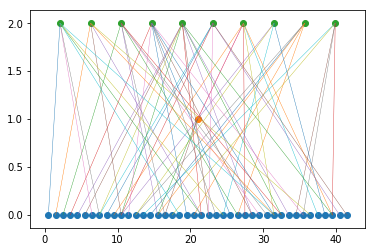

In [15]:
max_nodes_one_layer = np.max(length_of_each_layer)
for path in all_path_side2side:
    node1, node2 = path
    x1, y1 = dict_nodes_graph[node1]
    x2, y2 = dict_nodes_graph[node2]
    
    interval1 = max_nodes_one_layer/length_of_each_layer[y1]
    interval2 = max_nodes_one_layer/length_of_each_layer[y2]
    
    plt.plot([x1*interval1 + interval1/2, x2*interval2 + interval2/2], [y1, y2], linewidth=0.4)

for layer in range(max_length):
    interval = max_nodes_one_layer/length_of_each_layer[layer]
    plt.scatter((interval * np.arange(length_of_each_layer[layer]))+ interval/2, [layer]*length_of_each_layer[layer])

plt.show()

In [16]:
#visualize.draw_net(config, winner, prune_unused=False)
#visualize.plot_stats(stats, ylog=False, view=False)
#visualize.plot_species(stats, view=False)

In [20]:
winner_list = []
stats_list = []
for i in range(2,11):
    numbers = [*range(i)] # number 2 > number 1
    number_of_classification = len(numbers)
    number_of_sampling = 100

    list_y = y.tolist()
    digits_indexes = []
    for digit in numbers:
        li = [i for i in range(len(list_y)) if list_y[i] == digit]
        digits_indexes.extend(li[:number_of_sampling])

    samplesize = X[digits_indexes].shape[0]
    x_inputs =[tuple(c) for c in X[digits_indexes].tolist()]
    x_outputs = [tuple(c) for c in y[digits_indexes].reshape(samplesize,1).tolist()]

    def run(config_file):
        # Load configuration.
        config = neat.Config(
            neat.DefaultGenome,
            neat.DefaultReproduction,
            neat.DefaultSpeciesSet,
            neat.DefaultStagnation,
            config_file,
        )

        # Create the population, which is the top-level object for a NEAT run.
        p = neat.Population(config)

        # add a stdout reporter to show progress in the terminal
        reporter = neat.StdOutReporter(False)
        p.add_reporter(reporter)
        stats = neat.StatisticsReporter()
        p.add_reporter(stats)
        #checkpointer = neat.Checkpointer(100)
        #p.add_reporter(checkpointer)
        # Run for up to 300 generations.
        winner = p.run(eval_genomes, 1500)

        return [stats, winner]


    samplesize = len(x_outputs)

    local_dir = os.getcwd()
    config_path = os.path.join(local_dir, "config-feedforward-mnist"+str(number_of_classification))
    [stats, winner] = run(config_path)
    winner_list.append(winner)
    stats_list.append(stats)


 ****** Running generation 0 ****** 

Population's average fitness: 0.49448 stdev: 0.17953
Best fitness: 0.96500 - size: (2, 13) - species 2 - id 125
Average adjusted fitness: 0.489
Mean genetic distance 2.858, standard deviation 0.467
Population of 201 members in 24 species
Total extinctions: 0
Generation time: 0.729 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.57816 stdev: 0.16789
Best fitness: 0.96500 - size: (2, 13) - species 4 - id 125
Average adjusted fitness: 0.476
Mean genetic distance 2.946, standard deviation 0.455
Population of 201 members in 29 species
Total extinctions: 0
Generation time: 0.912 sec (0.820 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.62813 stdev: 0.18790
Best fitness: 0.97000 - size: (4, 15) - species 6 - id 493
Average adjusted fitness: 0.592
Mean genetic distance 2.972, standard deviation 0.468
Population of 202 members in 29 species
Total extinctions: 0
Generation time: 0.896 sec (0.846 av

Mean genetic distance 3.141, standard deviation 0.438
Population of 195 members in 40 species
Total extinctions: 0
Generation time: 2.500 sec (2.405 average)

 ****** Running generation 9 ****** 

Population's average fitness: 0.40081 stdev: 0.12582
Best fitness: 0.70000 - size: (8, 31) - species 32 - id 1274
Average adjusted fitness: 0.323
Mean genetic distance 3.134, standard deviation 0.447
Population of 195 members in 40 species
Total extinctions: 0
Generation time: 2.322 sec (2.397 average)

 ****** Running generation 0 ****** 

Population's average fitness: 0.19776 stdev: 0.07828
Best fitness: 0.38800 - size: (5, 32) - species 7 - id 109
Average adjusted fitness: 0.190
Mean genetic distance 2.852, standard deviation 0.343
Population of 199 members in 32 species
Total extinctions: 0
Generation time: 2.808 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.22965 stdev: 0.07480
Best fitness: 0.40400 - size: (6, 33) - species 11 - id 286
Average adjusted fitne

Population's average fitness: 0.19163 stdev: 0.06330
Best fitness: 0.41714 - size: (8, 47) - species 32 - id 365
Average adjusted fitness: 0.162
Mean genetic distance 3.026, standard deviation 0.384
Population of 208 members in 37 species
Total extinctions: 0
Generation time: 5.170 sec (4.873 average)

 ****** Running generation 4 ****** 

Population's average fitness: 0.19046 stdev: 0.06573
Best fitness: 0.41714 - size: (8, 47) - species 32 - id 365
Average adjusted fitness: 0.139
Mean genetic distance 3.080, standard deviation 0.403
Population of 199 members in 37 species
Total extinctions: 0
Generation time: 5.391 sec (4.976 average)

 ****** Running generation 5 ****** 

Population's average fitness: 0.20235 stdev: 0.06957
Best fitness: 0.41714 - size: (8, 47) - species 32 - id 365
Average adjusted fitness: 0.184
Mean genetic distance 3.089, standard deviation 0.397
Population of 200 members in 37 species
Total extinctions: 0
Generation time: 5.012 sec (4.982 average)

 ****** Runn

Mean genetic distance 3.095, standard deviation 0.376
Population of 200 members in 39 species
Total extinctions: 0
Generation time: 7.603 sec (7.432 average)

 ****** Running generation 8 ****** 

Population's average fitness: 0.15869 stdev: 0.05269
Best fitness: 0.33333 - size: (11, 59) - species 29 - id 751
Average adjusted fitness: 0.124
Mean genetic distance 3.098, standard deviation 0.391
Population of 199 members in 39 species
Total extinctions: 0
Generation time: 7.554 sec (7.445 average)

 ****** Running generation 9 ****** 

Population's average fitness: 0.16089 stdev: 0.05236
Best fitness: 0.33333 - size: (11, 59) - species 29 - id 751
Average adjusted fitness: 0.115
Mean genetic distance 3.106, standard deviation 0.392
Population of 190 members in 39 species
Total extinctions: 0
Generation time: 7.480 sec (7.449 average)

 ****** Running generation 0 ****** 

Population's average fitness: 0.10077 stdev: 0.03789
Best fitness: 0.21200 - size: (10, 64) - species 2 - id 12
Avera

In [ ]:
#visualize.plot_stats(stats, ylog=False, view=False)

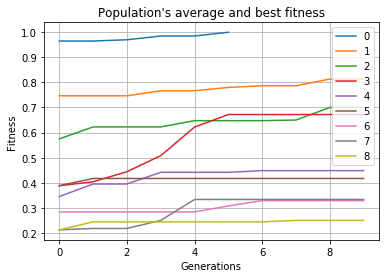

In [24]:
for i in range(9):
    statistics = stats_list[i]

    generation = range(len(statistics.most_fit_genomes))
    best_fitness = [c.fitness for c in statistics.most_fit_genomes]
    #avg_fitness = np.array(statistics.get_fitness_mean())
    #stdev_fitness = np.array(statistics.get_fitness_stdev())

    #plt.plot(generation, avg_fitness, "b-", label="average")
    #plt.plot(generation, avg_fitness - stdev_fitness, "g-.", label="-1 sd")
    #plt.plot(generation, avg_fitness + stdev_fitness, "g-.", label="+1 sd")
    plt.plot(generation, best_fitness, label=i)

plt.title("Population's average and best fitness")
plt.xlabel("Generations")
plt.ylabel("Fitness")
plt.grid()
plt.legend(loc="best")
plt.show()


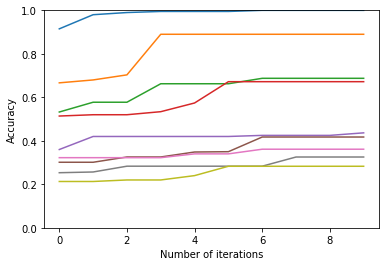

In [36]:
acc_list = [[0.91500,0.98000,0.99000,0.99500,0.99500,0.99500,1.0000, 1.0000, 1.0000, 1.0000],
[0.66667,0.68000,0.70333,0.89000,0.89000,0.89000,0.89000,0.89000,0.89000,0.89000],
[0.53250,0.57750,0.57750,0.66250,0.66250,0.66250,0.68750,0.68750,0.68750,0.68750],
[0.51400,0.52000,0.52000,0.53400,0.57400,0.67200,0.67200,0.67200,0.67200,0.67200],
[0.36000,0.42000,0.42000,0.42000,0.42000,0.42000,0.42500,0.42500,0.42500,0.43667],
[0.30143,0.30143,0.32571,0.32571,0.34857,0.35000,0.41750,0.41750,0.41750,0.41750],
[0.32250,0.32250,0.32250,0.32250,0.34000,0.34000,0.36143,0.36143,0.36143,0.36143],
[0.25333,0.25667,0.28333,0.28333,0.28333,0.28333,0.28333,0.32556,0.32556,0.32556],
[0.21300,0.21300,0.22000,0.22000,0.24000,0.28300,0.28300,0.28300,0.28300,0.28300]]

plt.ylim((0, 1))
for acc in acc_list:
    plt.plot(acc)

plt.xlabel('Number of iterations')
plt.ylabel('Accuracy')
plt.show()

In [4]:
# 十次之后2-10分类的准确率
num_list = [0.992, 0.8, 0.71, 0.538, 0.47167, 0.44143, 0.37250, 0.30333, 0.29800]
name_list = ['2','3','4','5','6','7','8','9','10']
plt.bar(range(len(num_list)), num_list, tick_label = name_list, alpha = 0.6)
plt.ylim((0, 1))

for x, y in zip(range(len(num_list)), num_list):
    # ha: horizontal alignment
    # va: vertical alignment
    plt.text(x , y - 0.06, '%.3f' % y, ha='center', va='bottom')

plt.xlabel('Number of classes')
plt.ylabel('Accuracy')
#plt.show()
plt.savefig("accuracy.eps")